In [23]:
### Control parameters
set.seed(999)
library(tidyverse)
library(MASS)
library(Rcpp)
library(splines)
library(LFBayes)
source("/Users/johnshamshoian/Documents/R_projects/LFBayes/Rfuns/Example/Simulation_funcs.R")
errorvar <- .025
SS <- 20
TT <- 20
t <- seq(from = 0, to = 1, length.out = TT)
s <- seq(from = 0, to = 1, length.out = SS)
n <- 60
tt <- list()
tt[[1]] <- 1:(TT*SS)
tt <- rep(tt, n)
p1 <- 12
p2 <- 12
q1 <- 3
q2 <- 3
Bt <- bs(t, df = p1, intercept = TRUE)
Bs <- bs(s, df = p2, intercept = TRUE)
Bt1 <- bs(t, df = p1, intercept = TRUE)
Bs1 <- bs(s, df = p2, intercept = TRUE)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


In [11]:
### Generate key model quantities

H <- GenerateH(q1, q2)
mu1 <- GenerateMu1(s,t)
Lambda <- Loading.Matern(t, p1, q1, Bt)
Gamma <- Loading.Brown.Bridge(s, p2, q2)
Cov <- kronecker(Bs%*%Gamma, Bt%*%Lambda)%*%H%*%t(kronecker(Bs%*%Gamma, Bt%*%Lambda)) + errorvar * diag(SS * TT)

In [12]:
### Generate data from model

x <- mvrnorm(n, mu  = as.vector(mu1), Sigma = Cov)
sx <- sd(x)
mx <- mean(x)
x <- (x-mx)/sx
Smooth_scaled_cov <- (Cov - errorvar * diag(SS * TT)) / sx^2
mu <- (mu1 - mx)/sx
y <- lapply(1:n, function(i) x[i,])
missing <- list()
for(ii in 1:n){
  missing[[ii]] <- numeric(0)
}
X <- cbind(rep(1, n))

In [ ]:
### Visualize a few trajectories



In [124]:
### MCMC control parameters

iter <- 5000 # Number of iterations
burnin <- 1000 # Burnin iterations
thin <- 1 # Thinning for each chain
nchain <- 1 # Number of chains
q1s <- 3 # Number of latent factors for functional dimension
q2s <- 3 # Number of latent factors for longitudinal dimension
alpha <- .05 # Type 1 error
neig <- 5 # Number of eigenfunctions for inference

In [125]:
### Processing

#MCMC <- mcmcWeakChains(y, missing, X, Bs1, Bt1, q1s, q2s, iter, thin, burnin, nchain, 1)
MCMC_eigen <- eigenLFChains(Bs1, Bt1, MCMC, neig, iter, burnin, nchain, s, t, alpha)

2
Starting post-processing...
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
All done!


In [126]:
### Prepare data for plotting

eigenfunction_tibble <- tibble(time = numeric(), type = character(),
                               value = numeric(), bound = character(),
                               number = numeric())
eigenfunction_tibble <- eigenfunction_tibble %>%
  add_row(value = c(MCMC_eigen$eigvecFuncmean,
                    MCMC_eigen$eigvecFunclower,
                    MCMC_eigen$eigvecFuncupper),
          number = rep(rep(1:neig, each = TT), 3),
          bound = rep(c("mean", "lower", "upper"), each = neig * TT),
          type = "Functional",
          time = rep(t, 3 * neig)) %>%
  add_row(value = c(MCMC_eigen$eigvecLongmean,
                    MCMC_eigen$eigvecLonglower,
                    MCMC_eigen$eigvecLongupper),
          number = rep(rep(1:neig, each = SS), 3),
          bound = rep(c("mean", "lower", "upper"), each = neig * SS),
          type = "Longitudinal",
          time = rep(s, 3 * neig))


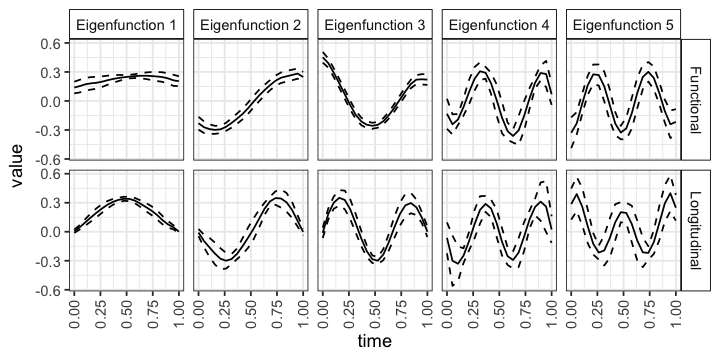

In [131]:
### Plot eigenfunctions

options(repr.plot.width=6, repr.plot.height=3)
number.labs <- paste("Eigenfunction", 1:neig)
names(number.labs) <- c("1":neig)
eigenfunction_tibble %>%
  ggplot(aes(time, value)) +
  geom_line(aes(linetype = bound)) +
  facet_grid(type ~ number, labeller = labeller(number = number.labs)) +
  scale_linetype_manual(values=c("dashed", "solid", "dashed"))+
  theme_bw() +
  theme(legend.position = "none", strip.background = element_rect(
        color="black", fill="#FFFFFF"), 
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  

In [137]:
### Percent variability explained by first 3 eigenfunctions in functional direction
rowMeans(MCMC_eigen$eigvalFunc)[p1:(p1-neig+1)]

[1] 0.682674156 0.239240152 0.050357017 0.007144532 0.005661619

In [138]:
### Percent variability explained by first 3 eigenfunctions in longitudinal direction
rowMeans(MCMC_eigen$eigvalLong)[p2:(p2-neig+1)]

[1] 0.750607554 0.153923315 0.069516410 0.006756391 0.005620855